In [40]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

np.random.seed(42)

In [41]:
# Load data
df = pd.read_csv('Health_Sleep_Statistics.csv')

In [42]:
df.head()

,User ID,Age,Gender,Sleep Quality,Bedtime,Wake-up Time,Daily Steps,Calories Burned,Physical Activity Level,Dietary Habits,Sleep Disorders,Medication Usage
0,1,25,f,8,23:00,06:30,8000,2500,medium,healthy,no,no
1,2,34,m,7,00:30,07:00,5000,2200,low,unhealthy,yes,yes
2,3,29,f,9,22:45,06:45,9000,2700,high,healthy,no,no
3,4,41,m,5,01:00,06:30,4000,2100,low,unhealthy,yes,no
4,5,22,f,8,23:30,07:00,10000,2800,high,medium,no,no


In [43]:
# Drop User ID column
df.drop('User ID', axis=1, inplace=True)

# Convert categorical features into numerical 
df['Gender'] = df['Gender'].map({'f': 0, 'm': 1})
df['Physical Activity Level'] = df['Physical Activity Level'].map({'low': 1, 'medium': 2, 'high': 3})
df['Dietary Habits'] = df['Dietary Habits'].map({'healthy': 1, 'medium': 2, 'unhealthy': 3})
df['Sleep Disorders'] = df['Sleep Disorders'].map({'no': 0, 'yes': 1})
df['Medication Usage'] = df['Medication Usage'].map({'no': 0, 'yes': 1})

# Convert Bedtime and Wake-up Time to num format (hours)
def time_to_hours(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours + minutes / 60

df['Bedtime'] = df['Bedtime'].apply(time_to_hours)
df['Wake-up Time'] = df['Wake-up Time'].apply(time_to_hours)

# Sleep Duration feature
df['Sleep Duration'] = (df['Wake-up Time'] - df['Bedtime']) % 24

In [44]:
df.head()

,Age,Gender,Sleep Quality,Bedtime,Wake-up Time,Daily Steps,Calories Burned,Physical Activity Level,Dietary Habits,Sleep Disorders,Medication Usage,Sleep Duration
0,25,0,8,23.00,6.50,8000,2500,2,1,0,0,7.5
1,34,1,7,0.50,7.00,5000,2200,1,3,1,1,6.5
2,29,0,9,22.75,6.75,9000,2700,3,1,0,0,8.0
3,41,1,5,1.00,6.50,4000,2100,1,3,1,0,5.5
4,22,0,8,23.50,7.00,10000,2800,3,2,0,0,7.5


In [45]:
# modeling frame: all features (everything except the target)

target = 'Sleep Quality'

# use every column except target (we already dropped 'User ID' earlier)
features_all = [c for c in df.columns if c != target]

df_model_all = df[features_all + [target]].copy()

print('df_model_all shape:', df_model_all.shape)
df_model_all.head()

df_model_all shape: (100, 12)


,Age,Gender,Bedtime,Wake-up Time,Daily Steps,Calories Burned,Physical Activity Level,Dietary Habits,Sleep Disorders,Medication Usage,Sleep Duration,Sleep Quality
0,25,0,23.00,6.50,8000,2500,2,1,0,0,7.5,8
1,34,1,0.50,7.00,5000,2200,1,3,1,1,6.5,7
2,29,0,22.75,6.75,9000,2700,3,1,0,0,8.0,9
3,41,1,1.00,6.50,4000,2100,1,3,1,0,5.5,5
4,22,0,23.50,7.00,10000,2800,3,2,0,0,7.5,8


In [46]:
# modeling frame: low-VIF interpretable features (for linear regression)

target = 'Sleep Quality'
features_small = ['Dietary Habits', 'Age', 'Gender', 'Sleep Disorders']

missing = [c for c in features_small + [target] if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

df_model_small = df[features_small + [target]].copy()

print('df_model_small shape:', df_model_small.shape)
df_model_small.head()

df_model_small shape: (100, 5)


,Dietary Habits,Age,Gender,Sleep Disorders,Sleep Quality
0,1,25,0,0,8
1,3,34,1,1,7
2,1,29,0,0,9
3,3,41,1,1,5
4,2,22,0,0,8


In [47]:
# train/test split for RF on all features

target = 'Sleep Quality'

X_all = df_model_all.drop(columns=[target]).copy()
y_all = df_model_all[target].copy()

from sklearn.model_selection import train_test_split
X_all_tr, X_all_te, y_all_tr, y_all_te = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

X_all_tr.shape, X_all_te.shape

((80, 11), (20, 11))

In [48]:
# train/test split for Linear on the 4-feature set

target = 'Sleep Quality'

X_sm = df_model_small.drop(columns=[target]).copy()
y_sm = df_model_small[target].copy()

X_sm_tr, X_sm_te, y_sm_tr, y_sm_te = train_test_split(
    X_sm, y_sm, test_size=0.2, random_state=42
)

X_sm_tr.shape, X_sm_te.shape

((80, 4), (20, 4))

In [49]:
# metrics helper (used for all models)

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {'r2': r2, 'mae': mae, 'rmse': rmse}

**Linear Regression for each feature individually**

In [50]:
# Linear Regression for each feature individually

import pandas as pd
import statsmodels.api as sm
from tabulate import tabulate

results_list = []

# function for OLS linear regression for individual features
def ols_regression_analysis(feature, robust: bool = True):
    X = df[[feature]]
    y = df['Sleep Quality']

    # add intercept
    X = sm.add_constant(X)

    model = sm.OLS(y, X)
    # Use robust (HC3) standard errors to make p-values more reliable under heteroskedasticity
    results = model.fit(cov_type="HC3") if robust else model.fit()

    r_squared = round(results.rsquared, 4)
    coef = round(results.params[feature], 4)
    intercept = round(results.params['const'], 4)

    # tidy p-values (both human-friendly flag and numeric value)
    p_raw = float(results.pvalues[feature])
    p_value_formatted = "P-value < 0.05" if p_raw < 0.05 else round(p_raw, 2)
    p_value = round(p_raw, 2)

    results_list.append([feature, r_squared, coef, intercept, p_value_formatted, p_value])


# features except Sleep Quality
features = df.drop(columns=['Sleep Quality']).columns

# OLS regression analysis for each feature
for feature in features:
    ols_regression_analysis(feature, robust=True)

# to DataFrame
results_df = pd.DataFrame(
    results_list,
    columns=['Feature', 'R-squared', 'Coefficient', 'Intercept', 'P-value', 'P-value (numeric)']
)

print(tabulate(results_df, headers='keys', tablefmt='pretty'))

# Not significant features (robust p >= 0.05)
not_sig = results_df.loc[results_df['P-value (numeric)'] >= 0.05, 'Feature'].tolist()
if not_sig:
    print("\n• Not significant (robust p ≥ 0.05):", ", ".join(not_sig))

+----+-------------------------+-----------+-------------+-----------+----------------+-------------------+
|    |         Feature         | R-squared | Coefficient | Intercept |    P-value     | P-value (numeric) |
+----+-------------------------+-----------+-------------+-----------+----------------+-------------------+
| 0  |           Age           |  0.7197   |   -0.1741   |  13.2688  | P-value < 0.05 |        0.0        |
| 1  |         Gender          |  0.6766   |    -2.84    |   8.42    | P-value < 0.05 |        0.0        |
| 2  |         Bedtime         |  0.7281   |   0.1346    |   5.403   | P-value < 0.05 |        0.0        |
| 3  |      Wake-up Time       |  0.0024   |   -0.1871   |  8.2837   |      0.64      |       0.64        |
| 4  |       Daily Steps       |  0.9531   |   0.0007    |  2.3701   | P-value < 0.05 |        0.0        |
| 5  |     Calories Burned     |  0.9478   |    0.006    |  -7.5491  | P-value < 0.05 |        0.0        |
| 6  | Physical Activity Lev

In [51]:
features

Index(['Age', 'Gender', 'Bedtime', 'Wake-up Time', 'Daily Steps',
       'Calories Burned', 'Physical Activity Level', 'Dietary Habits',
       'Sleep Disorders', 'Medication Usage', 'Sleep Duration'],
      dtype='object')

Based on EDA we saw high VIF for most features except the following. Hence, we only apply multiple regression on these low-VIF features:

- Dietary Habits
- Age
- Gender
- Sleep Disorders

**Multiple Linear Regression Model** based on low VIF features found in EDA

In [52]:
# Linear Regression on the 4 low-VIF features using the existing split
model = LinearRegression()
model.fit(X_sm_tr, y_sm_tr)

y_pred = model.predict(X_sm_te)

# use the shared metrics helper for consistency
lin_m = metrics(y_sm_te, y_pred)
print(f"Linear (4 features) metrics: {lin_m}")

# Coefficients table
coefficients = pd.DataFrame(model.coef_, X_sm_tr.columns, columns=['Coefficient'])
coefficients

Linear (4 features) metrics: {'r2': 0.9600766331366686, 'mae': 0.2624743658545281, 'rmse': 0.35448384617967504}


,Coefficient
Dietary Habits,-0.849170
Age,-0.028801
Gender,-0.635571
Sleep Disorders,-1.466069


In [53]:
lin = LinearRegression()
lin.fit(X_sm_tr, y_sm_tr)

lin_pred_te = lin.predict(X_sm_te)
lin_m = metrics(y_sm_te, lin_pred_te)  
lin_m

{'r2': 0.9600766331366686,
 'mae': 0.2624743658545281,
 'rmse': 0.35448384617967504}

In [54]:
import pandas as pd
import numpy as np
# Falls die Metriken noch nicht importiert sind:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Werte berechnen (falls noch nicht geschehen)
r2 = r2_score(y_sm_te, lin_pred_te)
mae = mean_absolute_error(y_sm_te, lin_pred_te)
rmse = np.sqrt(mean_squared_error(y_sm_te, lin_pred_te))

# Schöne englische Tabelle erstellen
metrics_display = pd.DataFrame({
    'Metric': ['R-Squared (R²)', 'MAE (Mean Absolute Error)', 'RMSE (Root Mean Sq. Error)'],
    'Score': [r2, mae, rmse]
})

# Runden auf 4 Stellen
metrics_display['Score'] = metrics_display['Score'].round(4)

# Anzeigen (ohne Index für sauberen Look)
print(metrics_display.to_string(index=False))

                    Metric  Score
            R-Squared (R²) 0.9601
 MAE (Mean Absolute Error) 0.2625
RMSE (Root Mean Sq. Error) 0.3545


In [55]:
import statsmodels.api as sm

# Wir nehmen die Trainingsdaten deiner 4 Features (X_sm_tr)
# WICHTIG: Bei statsmodels muss man die Konstante (Intercept) manuell hinzufügen
X_train_stats = sm.add_constant(X_sm_tr)

# Modell erstellen und fitten
model_stats = sm.OLS(y_sm_tr, X_train_stats).fit()

# Die ausführliche Tabelle anzeigen
print(model_stats.summary())

                            OLS Regression Results                            
Dep. Variable:          Sleep Quality   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     275.1
Date:                Tue, 25 Nov 2025   Prob (F-statistic):           5.50e-44
Time:                        23:13:25   Log-Likelihood:                -46.540
No. Observations:                  80   AIC:                             103.1
Df Residuals:                      75   BIC:                             115.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              10.5351      0.333     

**RandomForestRegressor** to predict Sleep Quality based on features.
Here we keep all features as multicollinearity is not an issue with RF

In [56]:
rf_base = RandomForestRegressor(n_estimators=200, random_state=42)
rf_base.fit(X_all_tr, y_all_tr)

rf_base_pred_te = rf_base.predict(X_all_te)
rfb = metrics(y_all_te, rf_base_pred_te) 
rfb

{'r2': 0.9787684670373312,
 'mae': 0.1062500000000001,
 'rmse': 0.2585077368281268}

Apply 5-fold Cross Validation

In [57]:
# RF tiny tuning — CV on TRAIN only, then one final check on TEST

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 6, 10],
    'min_samples_leaf': [1, 3]
}

rf_cv = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
)
rf_cv.fit(X_all_tr, y_all_tr)

rf_best = rf_cv.best_estimator_
rf_best_pred_te = rf_best.predict(X_all_te)

rfb2 = metrics(y_all_te, rf_best_pred_te)
print("best params:", rf_cv.best_params_)
rfb2

best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}


{'r2': 0.9774011119936458,
 'mae': 0.11399999999999988,
 'rmse': 0.2667020809817575}

In [58]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. Die besten Parameter aus dem GridSearch schön formatieren
best_params_table = pd.DataFrame(list(rf_cv.best_params_.items()), columns=['Hyperparameter', 'Optimized Value'])

# 2. Performance Metriken schön formatieren
# (Wir nutzen deine existierenden Variablen: y_all_te und rf_best_pred_te)
r2_rf = r2_score(y_all_te, rf_best_pred_te)
mae_rf = mean_absolute_error(y_all_te, rf_best_pred_te)
rmse_rf = np.sqrt(mean_squared_error(y_all_te, rf_best_pred_te))

metrics_rf_table = pd.DataFrame({
    'Metric': ['R-Squared (R²)', 'MAE (Mean Absolute Error)', 'RMSE (Root Mean Sq. Error)'],
    'Score': [r2_rf, mae_rf, rmse_rf]
})
metrics_rf_table['Score'] = metrics_rf_table['Score'].round(4)

# 3. Beides anzeigen
print("--TUNING RESULTS (Best Hyperparameters)--")
print(best_params_table.to_string(index=False))
print("\n")
print("--TEST PERFORMANCE (Random Forest)--")
print(metrics_rf_table.to_string(index=False))

--TUNING RESULTS (Best Hyperparameters)--
  Hyperparameter  Optimized Value
       max_depth              NaN
min_samples_leaf              1.0
    n_estimators            100.0


--TEST PERFORMANCE (Random Forest)--
                    Metric  Score
            R-Squared (R²) 0.9774
 MAE (Mean Absolute Error) 0.1140
RMSE (Root Mean Sq. Error) 0.2667


In [59]:
# RF on the 4-feature set

rf_small = RandomForestRegressor(n_estimators=100, random_state=42)
rf_small.fit(X_sm_tr, y_sm_tr)                 # 4-feature train
rf_small_pred_te = rf_small.predict(X_sm_te)   # 4-feature test

rf_small_m = metrics(y_sm_te, rf_small_pred_te) 
rf_small_m

{'r2': 0.9249437825434649,
 'mae': 0.3001666666666666,
 'rmse': 0.48604469387541344}

In [60]:
results = pd.DataFrame([
    ['linear (4 features, interpretable)', lin_m['r2'], lin_m['mae'], lin_m['rmse']],
    ['rf (4 features)', rf_small_m['r2'], rf_small_m['mae'], rf_small_m['rmse']],
    ['rf (all features, baseline)', rfb['r2'], rfb['mae'], rfb['rmse']],
    ['rf (all features, tuned)', rfb2['r2'], rfb2['mae'], rfb2['rmse']]
], columns=['model', 'r2_test', 'mae_test', 'rmse_test'])

results

,model,r2_test,mae_test,rmse_test
0,"linear (4 features, interpretable)",0.960077,0.262474,0.354484
1,rf (4 features),0.924944,0.300167,0.486045
2,"rf (all features, baseline)",0.978768,0.106250,0.258508
3,"rf (all features, tuned)",0.977401,0.114000,0.266702


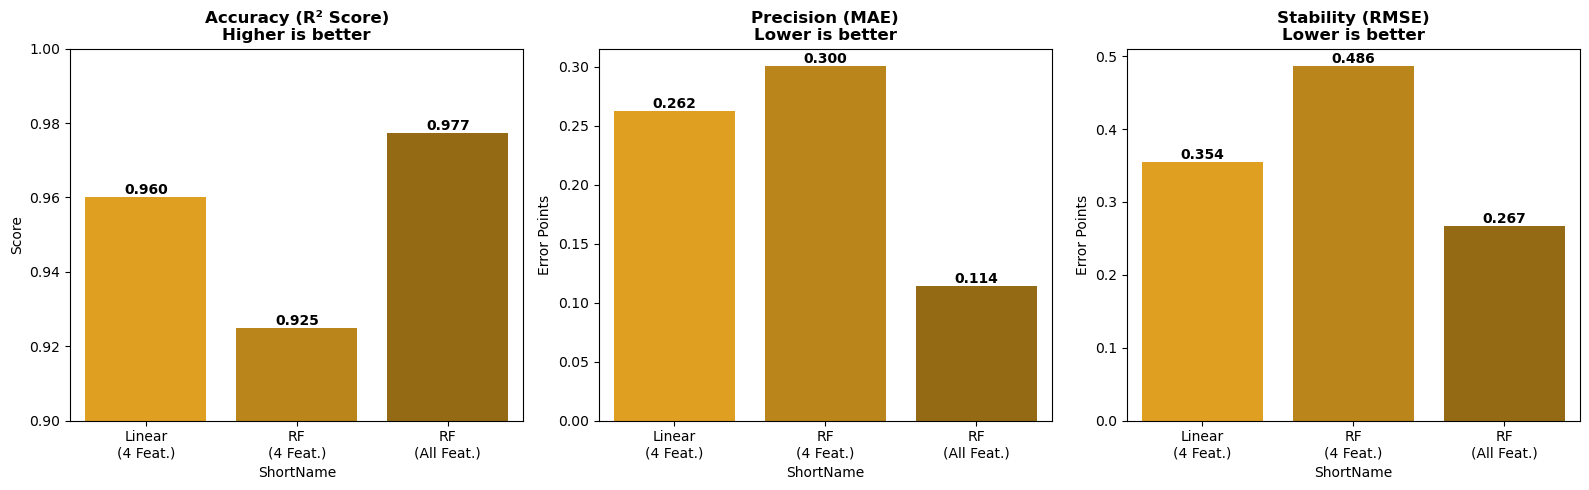

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Data (wie vorher)
plot_data = results.iloc[[0, 1, 3]].copy()
plot_data['ShortName'] = ['Linear\n(4 Feat.)', 'RF\n(4 Feat.)', 'RF\n(All Feat.)']

# --- CUSTOM ORANGE PALETTE ---
# Wir nutzen dein Orange #FFAA00 und dunklere Abstufungen für den Kontrast
# 1. Linear: #FFAA00 (Dein Original EBS Orange - Der "Held")
# 2. RF 4 Feat: #D48E00 (Etwas dunkler)
# 3. RF All Feat: #AA7100 (Noch dunkler / Kräftig)
colors = ['#FFAA00', '#D48E00', '#AA7100']

# Create Plot (3 Columns)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# --- 1. Accuracy (R2) ---
sns.barplot(data=plot_data, x='ShortName', y='r2_test', hue='ShortName', ax=axes[0], palette=colors, legend=False)
axes[0].set_title('Accuracy (R² Score)\nHigher is better', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_ylim(0.9, 1.0) # Zoom

# --- 2. Precision (MAE) ---
sns.barplot(data=plot_data, x='ShortName', y='mae_test', hue='ShortName', ax=axes[1], palette=colors, legend=False)
axes[1].set_title('Precision (MAE)\nLower is better', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Error Points')

# --- 3. Stability (RMSE) ---
sns.barplot(data=plot_data, x='ShortName', y='rmse_test', hue='ShortName', ax=axes[2], palette=colors, legend=False)
axes[2].set_title('Stability (RMSE)\nLower is better', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Error Points')

# Werte auf die Balken schreiben
metrics = ['r2_test', 'mae_test', 'rmse_test']
for i in range(3):
    for index, row in plot_data.iterrows():
        # Position finden
        pos = [0, 1, 2].index(index) if index in [0, 1, 2] else list(plot_data.index).index(index)
        # Wert schreiben
        axes[i].text(pos, row[metrics[i]], f"{row[metrics[i]]:.3f}", 
                     color='black', ha="center", va="bottom", fontweight='bold')

plt.tight_layout()
plt.show()

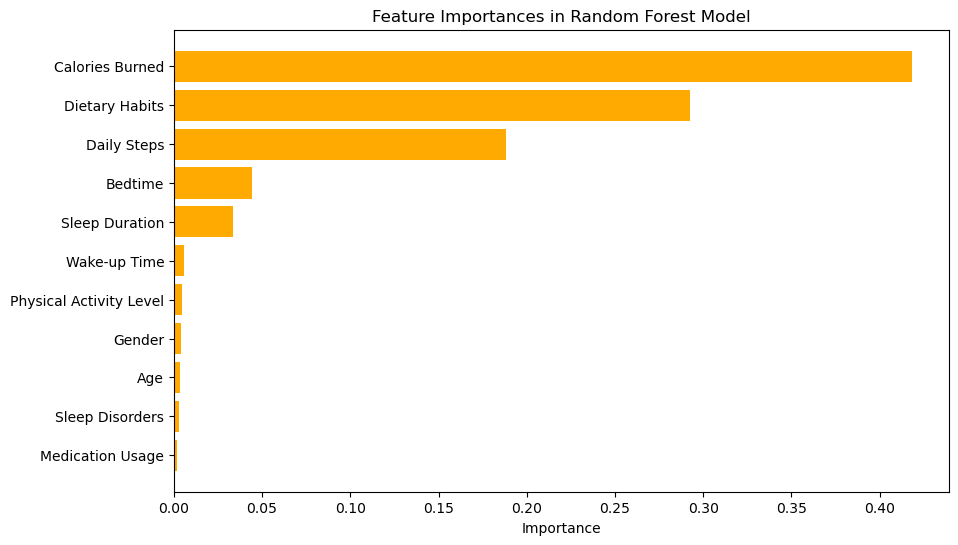

In [66]:
# All-features RF importances plot
model_for_importance = rf_best if 'rf_best' in globals() else rf_base
feature_names = X_all_tr.columns  # all-feature frame

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model_for_importance.feature_importances_,
}).sort_values('Importance', ascending=False)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Die Farbe 'skyblue' wurde durch den dunkleren Goldton ersetzt
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='#FFAA00')
plt.xlabel('Importance')
plt.title('Feature Importances in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

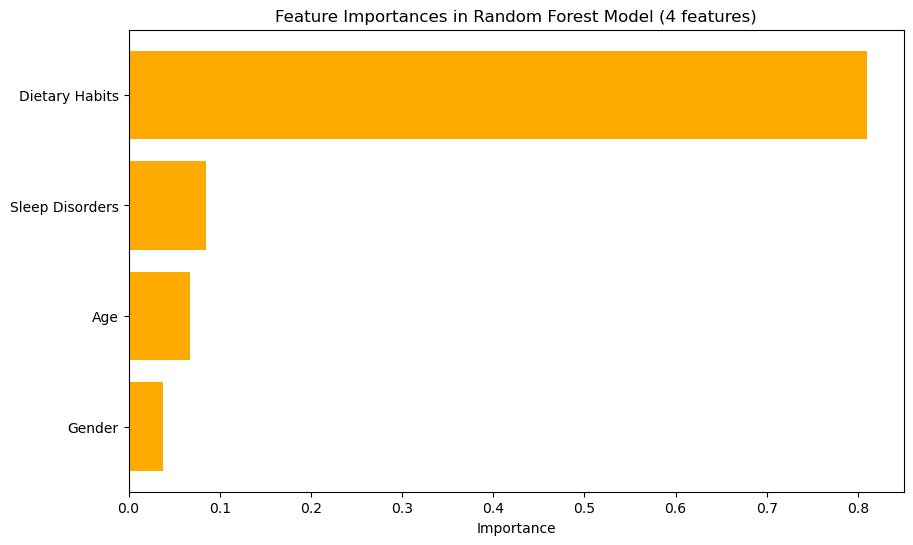

In [64]:
# 4-feature RF importances plot
feature_names_small = X_sm_tr.columns

feature_importances_small = pd.DataFrame({
    'Feature': feature_names_small,
    'Importance': rf_small.feature_importances_,
}).sort_values('Importance', ascending=False)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Die Farbe wurde zu dem helleren Goldton geändert
plt.barh(feature_importances_small['Feature'], feature_importances_small['Importance'], color='#FFAA00')
plt.xlabel('Importance')
plt.title('Feature Importances in Random Forest Model (4 features)')
plt.gca().invert_yaxis()
plt.show()